In [1]:
import fly_analysis as fa
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, correlate
from tqdm import tqdm 
from numba import jit
import pynumdiff

In [2]:
j53_kir_files = ["20240610_110919.braidz", "20240618_104047.braidz","20240618_134153.braidz"]
j53_kir = fa.braidz.read_multiple_braidz(j53_kir_files, "/home/buchsbaum/mnt/md0/Experiments/")

Reading /home/buchsbaum/mnt/md0/Experiments/20240610_110919.braidz using pyarrow
Reading /home/buchsbaum/mnt/md0/Experiments/20240618_104047.braidz using pyarrow
Reading /home/buchsbaum/mnt/md0/Experiments/20240618_134153.braidz using pyarrow


In [3]:
wtcs_files = ["20240702_140401.braidz","20240712_153309.braidz","20240715_171206.braidz"]
wtcs = fa.braidz.read_multiple_braidz(wtcs_files, "/home/buchsbaum/mnt/md0/Experiments/")

Reading /home/buchsbaum/mnt/md0/Experiments/20240702_140401.braidz using pyarrow
Reading /home/buchsbaum/mnt/md0/Experiments/20240712_153309.braidz using pyarrow
Reading /home/buchsbaum/mnt/md0/Experiments/20240715_171206.braidz using pyarrow


In [4]:
import numpy as np
from scipy.signal import savgol_filter
from numba import jit
from tqdm import tqdm

@jit(nopython=True)
def process_row(x, y, xvel, yvel):
    theta = np.arctan2(yvel, xvel)
    theta_u = np.unwrap(theta)
    angular_velocity = np.diff(theta_u)/0.01
    linear_velocity = np.sqrt(xvel**2 + yvel**2)
    return np.rad2deg(angular_velocity), linear_velocity

def get_data(data):
    angvels, linvels, trajs = [], [], []
    df = data["df"]
    stim = data["stim"]

    # Pre-filter df to only include rows with unique_obj_id in stim
    unique_obj_ids = set(stim["unique_obj_id"])
    df_filtered = df[df["unique_obj_id"].isin(unique_obj_ids)]

    # Group data by unique_obj_id
    grouped = df_filtered.groupby("unique_obj_id")

    for _, row in tqdm(stim.iterrows(), total=len(stim)):
        obj_id = row["unique_obj_id"]
        frame = row["frame"]

        grp = grouped.get_group(obj_id)

        # calculate total distance covered by the trajectory
        dist = np.linalg.norm(grp[['x', 'y', 'z']].diff().values, axis=1).sum()

        if dist < 0.5:
            continue
        
        if len(grp) < 300:
            continue

        stim_indices = np.where(grp.frame == frame)[0]
        if len(stim_indices) == 0:
            continue

        stim_idx = stim_indices[0]
        start_idx = stim_idx - 50
        end_idx = stim_idx + 100

        if start_idx < 0 or end_idx >= len(grp):
            continue

        x = grp.x.to_numpy()
        y = grp.y.to_numpy()
        dxdt = grp.xvel.to_numpy()
        dydt = grp.yvel.to_numpy()
        
        angular_velocity, linear_velocity = process_row(x, y, dxdt, dydt)
        angvels.append(angular_velocity[start_idx:end_idx])
        linvels.append(linear_velocity[start_idx:end_idx])
        trajs.append(np.column_stack((x[start_idx:end_idx], y[start_idx:end_idx])))

    return np.array(angvels), np.array(linvels), np.array(trajs)

In [5]:
j53_angvels, j53_linvels, j53_trajs = get_data(j53_kir)
wtcs_angvels, wtcs_linvels, wtcs_trajs = get_data(wtcs)

100%|██████████| 417/417 [00:00<00:00, 598.84it/s]


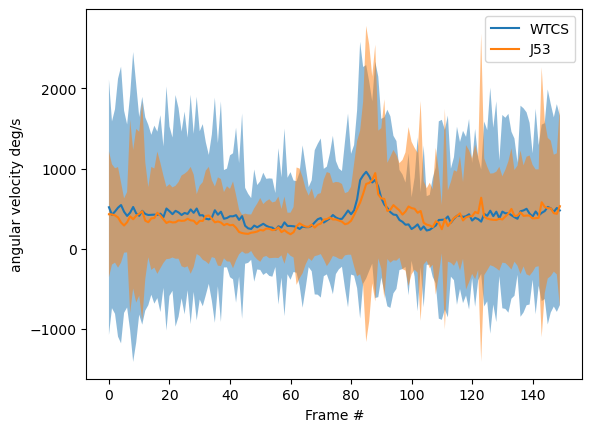

In [7]:
fig = plt.figure()

j53_mean = np.nanmean(np.abs(j53_angvels), axis=0)
j53_std = np.nanstd(np.abs(j53_angvels), axis=0)
X_j53 = np.arange(len(j53_mean))

wtcs_mean = np.nanmean(np.abs(wtcs_angvels), axis=0)
wtcs_std = np.nanstd(np.abs(wtcs_angvels), axis=0)
X_wtcs = np.arange(len(wtcs_mean))

plt.plot(X_wtcs, wtcs_mean, label="WTCS")
plt.fill_between(X_wtcs, wtcs_mean - wtcs_std, wtcs_mean + wtcs_std, alpha=0.5)

plt.plot(X_j53, j53_mean, label="J53")
plt.fill_between(X_j53, j53_mean - j53_std, j53_mean + j53_std, alpha=0.5)

plt.xlabel("Frame #")
plt.ylabel("angular velocity deg/s")
plt.legend()
plt.show()
